In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
url = "https://data.ojp.usdoj.gov/resource/ynf5-u8nk.csv"
df = pd.read_csv(url)

# Explore the dataset
print(df.head())
print(df.info())
print(df.describe())

   id gender   race age_at_release  residence_puma gang_affiliated  \
0   1      M  BLACK          43-47              16           False   
1   2      M  BLACK          33-37              16           False   
2   3      M  BLACK    48 or older              24           False   
3   4      M  WHITE          38-42              16           False   
4   5      M  WHITE          33-37              16           False   

   supervision_risk_score_first supervision_level_first  \
0                           3.0                Standard   
1                           6.0             Specialized   
2                           7.0                    High   
3                           7.0                    High   
4                           4.0             Specialized   

         education_level dependents  ... drugtests_meth_positive  \
0  At least some college  3 or more  ...                0.000000   
1   Less than HS diploma          1  ...                0.000000   
2  At least some col

In [3]:
# Drop unnecessary column
df = df.drop(columns=["id"])

# Convert categorical variables to dummy variables
df = pd.get_dummies(df, drop_first=True)

# Handle missing values if any
df = df.dropna()

# Define features and target variable
X = df.drop(
    columns=[
        "recidivism_within_3years",
        "recidivism_arrest_year1",
        "recidivism_arrest_year2",
        "recidivism_arrest_year3",
    ],
    axis=1,
)
y = df["recidivism_within_3years"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

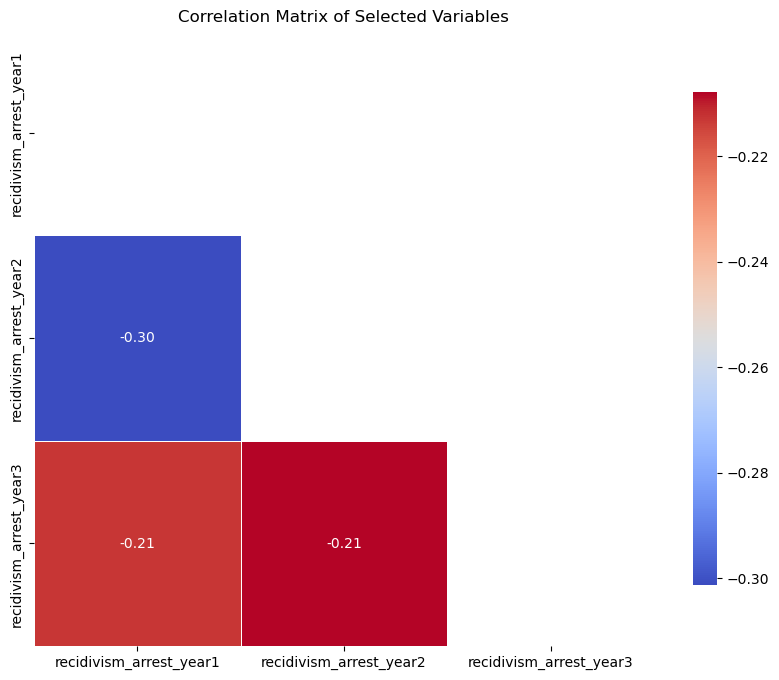

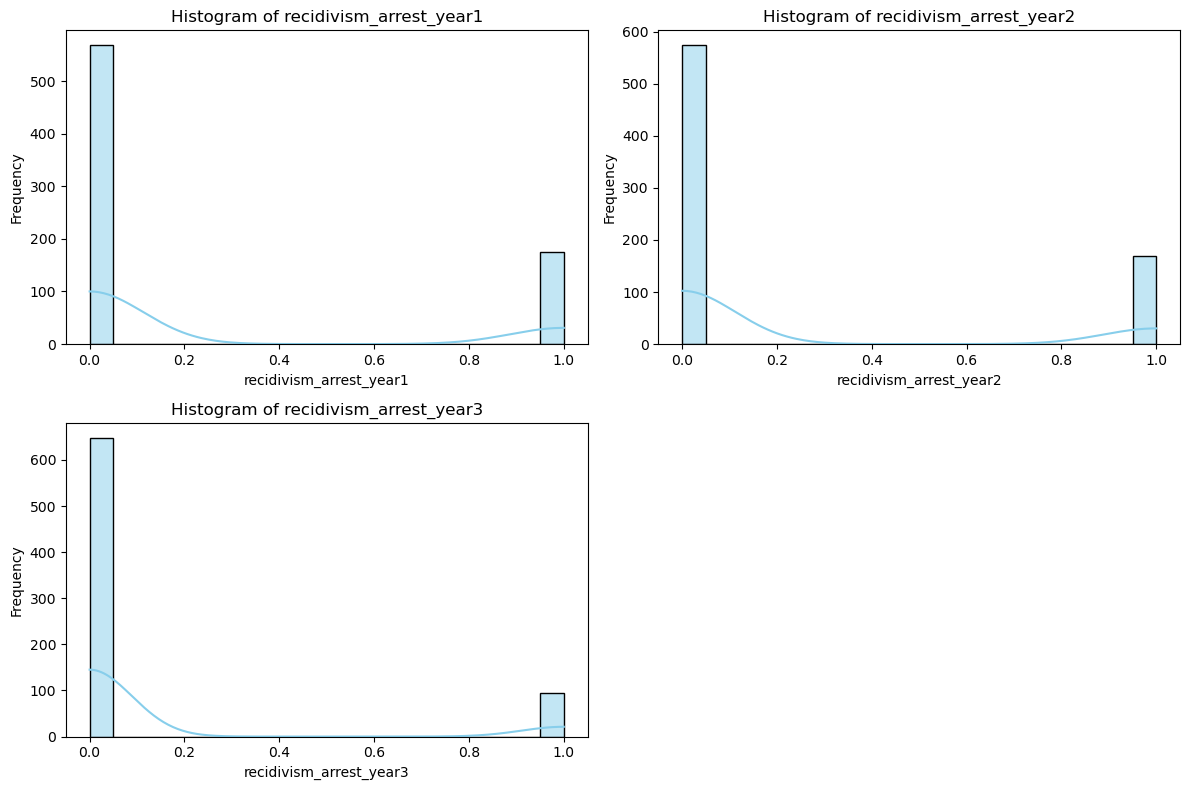

In [12]:
# Correlation Matrix
selected_vars = ["recidivism_arrest_year1", "recidivism_arrest_year2", "recidivism_arrest_year3"]
subset_df = df[selected_vars].astype(int)

correlation_matrix = df[selected_vars].corr()

# Set a threshold for correlation values
threshold = 0.5  # Adjust as needed
highly_correlated = (correlation_matrix.abs() > threshold) & (correlation_matrix < 1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Customize the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask, fmt=".2f", linewidths=.5, cbar_kws={"shrink": 0.8})

plt.title('Correlation Matrix of Selected Variables')
plt.show()

# # Histogram Plots
plt.figure(figsize=(12, 8))

# Loop through selected variables and create histograms
for i, var in enumerate(selected_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(subset_df[var], kde=True, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train the Lasso logistic regression model
lasso_model = LogisticRegression(penalty="l1", solver="liblinear", random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# Print coefficients
coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": lasso_model.coef_[0]})
print(coef_df)

In [ ]:
# Select features based on non-zero coefficients
selected_features = X.columns[lasso_model.coef_[0] != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
N = 10  # Number of top features to display
top_features = coef_df.nlargest(N, "Coefficient")

fig = px.bar(
    top_features,
    x="Coefficient",
    y="Feature",
    orientation="h",
    title=f"Top {N} Lasso Logistic Regression Coefficients",
)
fig.show()

In [ ]:
N = 10  # Number of top features to display
top_features = coef_df.nlargest(N, "Coefficient")

fig = px.bar(
    top_features,
    x="Coefficient",
    y="Feature",
    orientation="h",
    title=f"Top {N} Lasso Logistic Regression Coefficients"
)
fig.show()

In [ ]:
# ROC Curve
y_prob = lasso_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    lasso_model, X_train_scaled, y_train, cv=5
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.xlabel("Number of training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Hyperparameter Tuning (example with regularization strength)
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(
    LogisticRegression(penalty="l1", solver="liblinear", random_state=42), param_grid, cv=5
)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Re-train the model with the best hyperparameters
best_lasso_model = grid_search.best_estimator_
best_lasso_model.fit(X_train_scaled, y_train)